Реализуем Стохастический градиентный бустинг, используя средства библиотеки _PyTorch_, для задачи бинарной классификации

In [24]:
import torch
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
torch.manual_seed(0)

L = 1000
n = 2
K = 1000

X = torch.randn([L, n])
w_true = torch.randn([n])
Y = torch.ones([L])
Y[X @ w_true < 0] = -1

$$\hat{w} = \arg \min_{w \in R^n} \frac{1}{L} \sum_{i=1}^{L}{\log_2{(1 + \exp^{-y_i \bold{w}^T \bold{x_i}})}}$$

$a_k = \frac{1}{k}, k=\overline{1, K}$

In [29]:
torch.manual_seed(0)
np.random.seed(0)

# First shot into `w`=: w_init
w = torch.randn([n], requires_grad=True)
list_loss = []


for k in range(1, K+1):
    # Calculate loss L on k-th step
    with torch.no_grad():
        list_loss.append(
            torch.mean(torch.log2(1 + torch.exp(-Y * (X @ w))))
        )
    # Choose random element from sample
    ind = np.random.randint(low=0, high=1)
    alpha = 1 / k
    
    # Calculate loss on the selected random element
    q = torch.log2(1 + torch.exp(-Y[ind] * (X[ind] @ w)))
    # Calculate \hat{q}
    q.backward()
    # Make Gradient step
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)
    # Zeroise gradient
    w.grad.zero_()

$a_k = \frac{1}{\sqrt{k}}, k=\overline{1, K}$

In [31]:
torch.manual_seed(0)
np.random.seed(0)

# First shot into `w`=: w_init
w = torch.randn([n], requires_grad=True)
list_loss_sqrt = []

for k in range(1, K+1):
    # Calculate loss L on k-th step
    with torch.no_grad():
        list_loss_sqrt.append(
            torch.mean(torch.log2(1 + torch.exp(-Y * (X @ w)))).float().item()
        )
    # Choose random element from sample
    ind = np.random.randint(low=0, high=1)
    alpha = 1 / np.sqrt(k)
    
    # Calculate loss on the selected random element
    q = torch.log2(1 + torch.exp(-Y[ind] * (X[ind] @ w)))
    # Calculate \hat{q}
    q.backward()
    # Make Gradient step
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)
    # Zeroise gradient
    w.grad.zero_()

In [32]:
torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

dataset = torch.utils.data.TensorDataset(X, Y)
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Optimizer gets list of parameters
optimizer = torch.optim.SGD([w], lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
                                              lr_lambda=lambda k: 1 / np.sqrt(k+1))

list_loss_sqrt_torch = []
for x, y in generator:
    optimizer.zero_grad()
    # Calculate loss on k-th step
    with torch.no_grad():
        list_loss_sqrt_torch.append(
            torch.mean(torch.log2(1 + torch.exp(-Y * (X @ w)))).float().item()
        )
    q = torch.log2(1 + torch.exp(-y * (x @ w))).mean()

    q.backward()

    optimizer.step()
    scheduler.step()

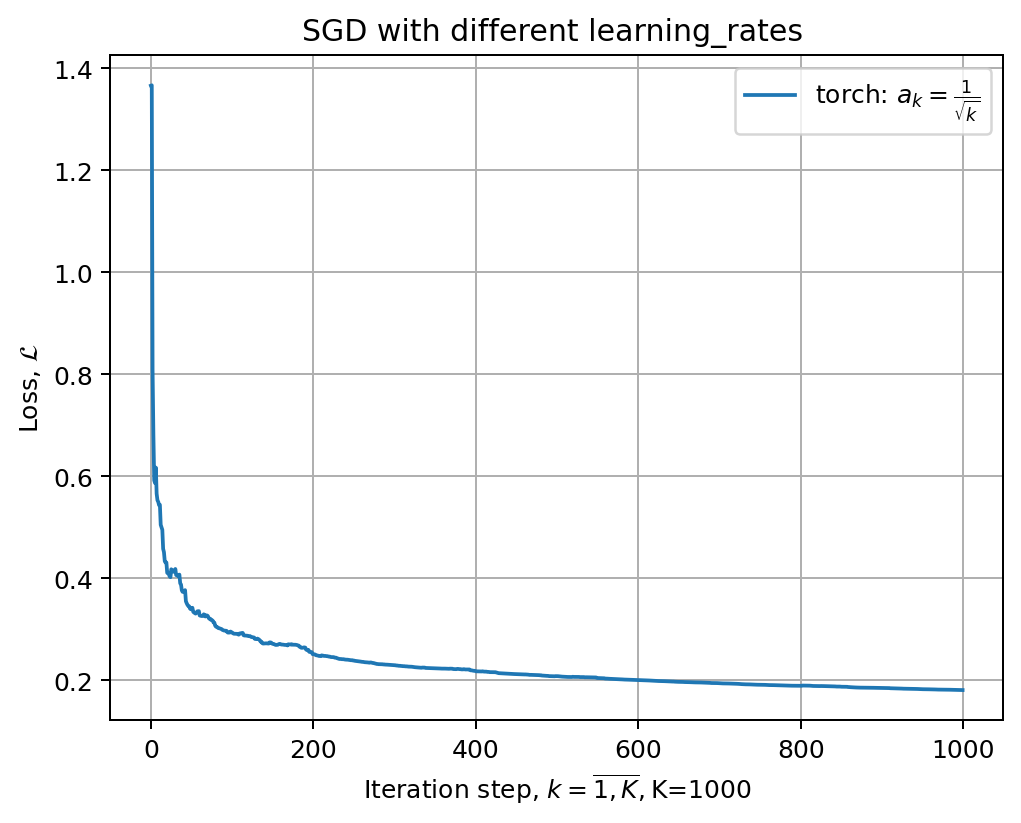

In [42]:
plt.figure(dpi=180)
plt.grid()
# plt.plot(list_loss, label='manual: $a_k = 1/k$')
# plt.plot(list_loss_sqrt, label='manual: $a_k = \\frac{1}{\sqrt{k}}$')
plt.plot(list_loss_sqrt_torch, label='torch: $a_k = \\frac{1}{\sqrt{k}}$')
plt.xlabel("Iteration step, $k=\overline{1, K},$" + f"{K=}")
plt.ylabel("Loss, $\mathcal{L}$")
plt.title("SGD with different learning_rates ")
plt.legend(loc='best')
plt.show()